# Dependencias

In [83]:
import numpy as np
import pandas as pd

from datetime import datetime

from sklearn.linear_model import LinearRegression,Ridge
from sklearn.metrics import roc_auc_score, r2_score, mean_absolute_error
from scikitplot.metrics import plot_roc
from sklearn.feature_selection import VarianceThreshold, f_regression,SelectKBest
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.impute import SimpleImputer

from varclushi import VarClusHi
from scipy import stats

import cufflinks as cf
import matplotlib.pyplot as plt
import seaborn as sns

import os

cf.go_offline()
pd.set_option('display.max_columns',None)

# Lectura de datos

In [2]:
ruta='/home/oscarjarillo/Documentos/Análisis Multivariado/Varios/archive/'
listArchivos = sorted([os.path.join(ruta,arch) 
                       for arch in os.listdir(ruta)])
listArchivos

['/home/oscarjarillo/Documentos/Análisis Multivariado/Varios/archive/Air Conditioners.csv',
 '/home/oscarjarillo/Documentos/Análisis Multivariado/Varios/archive/All Appliances.csv',
 '/home/oscarjarillo/Documentos/Análisis Multivariado/Varios/archive/All Books.csv',
 '/home/oscarjarillo/Documentos/Análisis Multivariado/Varios/archive/All Car and Motorbike Products.csv',
 '/home/oscarjarillo/Documentos/Análisis Multivariado/Varios/archive/All Electronics.csv',
 '/home/oscarjarillo/Documentos/Análisis Multivariado/Varios/archive/All English.csv',
 '/home/oscarjarillo/Documentos/Análisis Multivariado/Varios/archive/All Exercise and Fitness.csv',
 '/home/oscarjarillo/Documentos/Análisis Multivariado/Varios/archive/All Grocery and Gourmet Foods.csv',
 '/home/oscarjarillo/Documentos/Análisis Multivariado/Varios/archive/All Hindi.csv',
 '/home/oscarjarillo/Documentos/Análisis Multivariado/Varios/archive/All Home and Kitchen.csv',
 '/home/oscarjarillo/Documentos/Análisis Multivariado/Varios/ar

In [3]:
df = pd.concat(map(pd.read_csv,listArchivos),ignore_index=True)
df.head()

,name,main_category,sub_category,image,link,ratings,no_of_ratings,discount_price,actual_price,Unnamed: 0
0,Lloyd 1.5 Ton 3 Star Inverter Split Ac (5 In 1...,appliances,Air Conditioners,https://m.media-amazon.com/images/I/31UISB90sY...,https://www.amazon.in/Lloyd-Inverter-Convertib...,4.2,"2,255","₹32,999","₹58,990",NaN
1,LG 1.5 Ton 5 Star AI DUAL Inverter Split AC (C...,appliances,Air Conditioners,https://m.media-amazon.com/images/I/51JFb7FctD...,https://www.amazon.in/LG-Convertible-Anti-Viru...,4.2,"2,948","₹46,490","₹75,990",NaN
2,LG 1 Ton 4 Star Ai Dual Inverter Split Ac (Cop...,appliances,Air Conditioners,https://m.media-amazon.com/images/I/51JFb7FctD...,https://www.amazon.in/LG-Inverter-Convertible-...,4.2,"1,206","₹34,490","₹61,990",NaN
3,LG 1.5 Ton 3 Star AI DUAL Inverter Split AC (C...,appliances,Air Conditioners,https://m.media-amazon.com/images/I/51JFb7FctD...,https://www.amazon.in/LG-Convertible-Anti-Viru...,4.0,69,"₹37,990","₹68,990",NaN
4,Carrier 1.5 Ton 3 Star Inverter Split AC (Copp...,appliances,Air Conditioners,https://m.media-amazon.com/images/I/41lrtqXPiW...,https://www.amazon.in/Carrier-Inverter-Split-C...,4.1,630,"₹34,490","₹67,790",NaN


In [4]:
df.shape

(1103170, 10)

In [5]:
df.drop('Unnamed: 0',axis=1,inplace=True)

In [6]:
X = df.copy()
X['cantidad'] = 1
X = X.groupby(by=['name','ratings','no_of_ratings','discount_price','actual_price'],as_index=False).agg({'cantidad':'sum'})

In [7]:
X.shape,df.dropna().shape

((290435, 6), (681360, 9))

In [8]:
X['cantidad'].sum()

681360

In [9]:
X['actual_price'] = [''.join(v.split('₹')[-1].split(',')) for v in X['actual_price']]
X['discount_price'] = [''.join(v.split('₹')[-1].split(',')) for v in X['discount_price']]

In [10]:
for v in list(X.columns)[1:][:-1]:
    X[v] = pd.to_numeric(X[v],errors='coerce')

In [11]:
X['discount'] = X['actual_price'] - X['discount_price']

In [12]:
X['ventas'] = X['discount_price']*X['cantidad']

In [13]:
X.head()

,name,ratings,no_of_ratings,discount_price,actual_price,cantidad,discount,ventas
0,"""A"" PLUS Hygiene Portable Room Air Purifier an...",4.1,911.0,1499.0,2678.0,6,1179.0,8994.0
1,"""DN Enterprises"" Women's Wallet/Clutch/Hand Ba...",5.0,1.0,310.0,699.0,2,389.0,620.0
2,"""DN Enterprises"" Women's Wallet/Clutch/Hand Ba...",3.4,24.0,349.0,1299.0,2,950.0,698.0
3,"""GOMUKH” Gangajal The Purest Holy Water Direct...",4.8,5.0,329.0,399.0,2,70.0,658.0
4,"""Guruji Swaroop Bracelet with Shiv Ji Swaroop ...",4.1,5.0,239.0,399.0,2,160.0,478.0


# Definición de variables

In [14]:
X.insert(0,'id',X.index+1)

In [55]:
um = ['id']
vart = ['ventas']
varc = ['ratings','no_of_ratings','discount','cantidad']

# Análisis exploratorio

## Valores nulos

In [56]:
nulos = 1-X.describe().T[['count']]/len(X)
nulos

,count
id,0.000000
ratings,0.018954
no_of_ratings,0.088192
discount_price,0.000000
actual_price,0.000000
cantidad,0.000000
discount,0.000000
ventas,0.000000


In [57]:
im = SimpleImputer(strategy='median')
im.fit(X[varc])

SimpleImputer(strategy='median')

In [58]:
Xi = pd.DataFrame(im.transform(X[varc]),columns=varc)
Xi[um+vart] = X[um+vart]

In [59]:
Xi.head()

,ratings,no_of_ratings,discount,cantidad,id,ventas
0,4.1,911.0,1179.0,6.0,1,8994.0
1,5.0,1.0,389.0,2.0,2,620.0
2,3.4,24.0,950.0,2.0,3,698.0
3,4.8,5.0,70.0,2.0,4,658.0
4,4.1,5.0,160.0,2.0,5,478.0


In [60]:
nulos = 1-Xi.describe().T[['count']]/len(Xi)
nulos

,count
ratings,0.0
no_of_ratings,0.0
discount,0.0
cantidad,0.0
id,0.0
ventas,0.0


## Varianza nula 

In [61]:
vt = VarianceThreshold()
vt.fit(Xi[varc])

VarianceThreshold()

In [62]:
fuera = [a for a,b in zip(varc,vt.get_support())if not b]
fuera

[]

## Seleccion de variables con mejor poder predictivo

In [63]:
sk = SelectKBest(k=len(varc),score_func=f_regression)
sk.fit(Xi[varc],Xi[vart[0]])

SelectKBest(k=4, score_func=<function f_regression at 0x7f76af5157e0>)

In [64]:
pd.DataFrame(zip(varc,sk.scores_),columns=['var','score']).set_index('var').sort_values(by='score',
                                                    ascending=False).iplot(kind='bar',color='orange')

In [65]:
sk = SelectKBest(k=3,score_func=f_regression)
sk.fit(Xi[varc],Xi[vart[0]])

SelectKBest(k=3, score_func=<function f_regression at 0x7f76af5157e0>)

In [66]:
best = [a for a,b in zip(varc,sk.get_support())if b]
best

['ratings', 'no_of_ratings', 'cantidad']

## Valores extremos

array([[<AxesSubplot:title={'center':'ratings'}>,
        <AxesSubplot:title={'center':'no_of_ratings'}>],
       [<AxesSubplot:title={'center':'cantidad'}>, <AxesSubplot:>]],
      dtype=object)

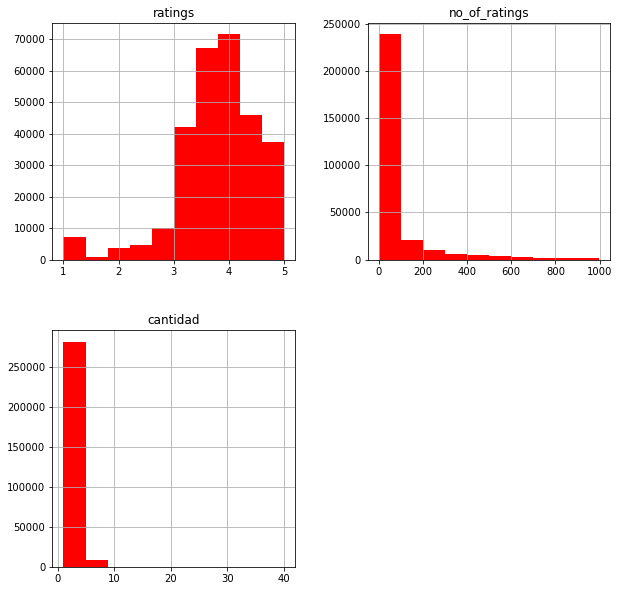

In [67]:
Xi[best].hist(figsize=(10,10),color='red')

In [68]:
for v,li,ls in Xi[best].describe(percentiles=[0.01,0.99]).T[['1%','99%']].reset_index().values:
    Xi[f'ex_{v}'] = ((Xi[v]<li)|(Xi[v]>ls)).astype(int)
Xi['ex_'] = Xi.filter(like='ex_').max(axis=1)
Xi['ex_'].value_counts(1)

0    0.985962
1    0.014038
Name: ex_, dtype: float64

In [69]:
for v,li,ls in Xi[best].describe(percentiles=[0.01,0.99]).T[['1%','99%']].reset_index().values:
    Xi.loc[Xi[v]<li,v]=np.nan
    Xi.loc[Xi[v]>ls,v]=np.nan

In [70]:
im.fit(Xi[best])

SimpleImputer(strategy='median')

In [71]:
Xj = pd.DataFrame(im.transform(Xi[best]),columns=best)
Xj[um+vart] = Xi[um+vart]

array([[<AxesSubplot:title={'center':'ratings'}>,
        <AxesSubplot:title={'center':'no_of_ratings'}>],
       [<AxesSubplot:title={'center':'cantidad'}>, <AxesSubplot:>]],
      dtype=object)

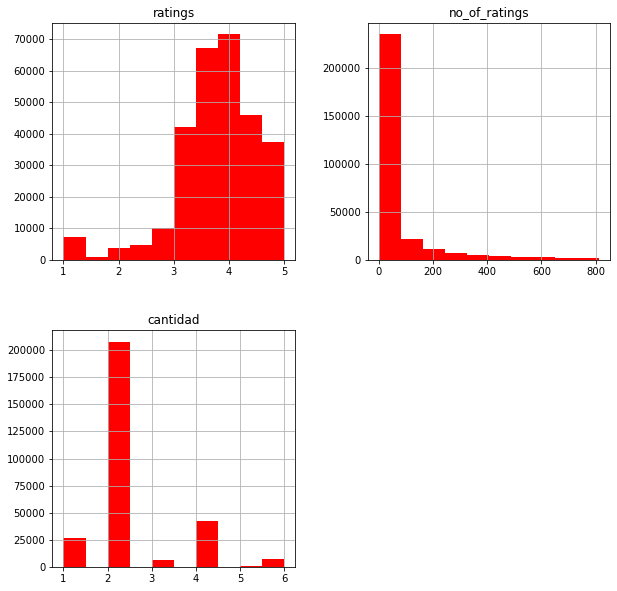

In [72]:
Xj[best].hist(figsize=(10,10),color='red')

# Partición

In [73]:
Xt,Xv,yt,yv = train_test_split(Xj[um+best],Xj[um+vart],train_size=0.7)
Xt.reset_index(drop=True,inplace=True)
Xv.reset_index(drop=True,inplace=True)
yt.reset_index(drop=True,inplace=True)
yv.reset_index(drop=True,inplace=True)

# Aprendizaje

## Regresión lineal

In [74]:
modelo1 = LinearRegression(n_jobs=-1)
modelo1.fit(Xt[best],yt[vart[0]])

LinearRegression(n_jobs=-1)

### Validación del modelo

In [75]:
St1 = Xt.merge(yt,on=um,how='inner')
Sv1 = Xv.merge(yv,on=um,how='inner')

In [76]:
St1['y^'] = modelo1.predict(Xt[best])
Sv1['y^'] = modelo1.predict(Xv[best])

In [77]:
print(mean_absolute_error(y_pred=St1['y^'],y_true=St1[vart[0]]))
print(mean_absolute_error(y_pred=Sv1['y^'],y_true=Sv1[vart[0]]))

4638.648550880236
4630.199159735378


In [78]:
print(r2_score(y_pred=St1['y^'],y_true=St1[vart[0]]))
print(r2_score(y_pred=Sv1['y^'],y_true=Sv1[vart[0]]))

0.01972763884807993
0.015426214186476939


<AxesSubplot:ylabel='Density'>

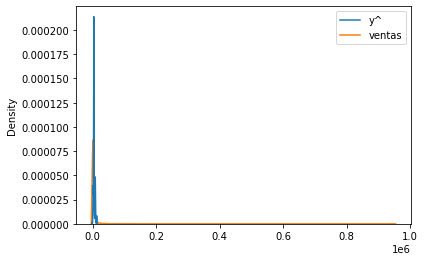

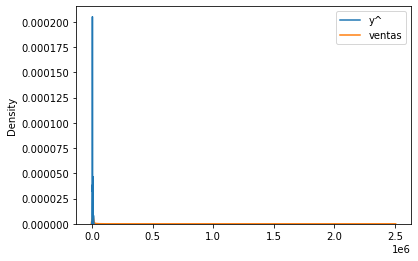

In [79]:
plt.figure()
sns.kdeplot(data=St1[['y^']+vart])
plt.figure()
sns.kdeplot(data=Sv1[['y^']+vart])

In [80]:
St1.head()

,id,ratings,no_of_ratings,cantidad,ventas,y^
0,117881,3.4,9.0,2.0,998.0,2989.890826
1,137859,1.0,1.0,2.0,1756.0,495.574545
2,94367,5.0,6.0,2.0,2698.0,4637.573146
3,262819,5.0,1.0,1.0,1549.0,2427.698591
4,211691,3.3,59.0,2.0,1136.0,2977.739987


## Regresión Cresta

In [84]:
hp=dict(alpha=np.arange(0.1,2,0.1))
modelo2 = Ridge()
grid = GridSearchCV(param_grid=hp,
                   cv=5,
                   scoring='neg_mean_absolute_error',
                   n_jobs=-1,
                   verbose=True,
                   estimator=modelo2)

In [85]:
grid.fit(Xt[best],yt[vart[0]])

Fitting 5 folds for each of 19 candidates, totalling 95 fits


GridSearchCV(cv=5, estimator=Ridge(), n_jobs=-1,
             param_grid={'alpha': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3,
       1.4, 1.5, 1.6, 1.7, 1.8, 1.9])},
             scoring='neg_mean_absolute_error', verbose=True)

In [86]:
grid.best_params_

{'alpha': 1.9000000000000001}

In [87]:
modelo2 = grid.best_estimator_
modelo2

Ridge(alpha=1.9000000000000001)

In [88]:
modelo2.fit(Xt[best],yt[vart[0]])

Ridge(alpha=1.9000000000000001)

### Validación del modelo

In [89]:
St2 = Xt.merge(yt,on=um,how='inner')
Sv2 = Xv.merge(yv,on=um,how='inner')

In [90]:
St2['y^'] = modelo2.predict(Xt[best])
Sv2['y^'] = modelo2.predict(Xv[best])

In [91]:
print(mean_absolute_error(y_pred=St2['y^'],y_true=St2[vart[0]]))
print(mean_absolute_error(y_pred=Sv2['y^'],y_true=Sv2[vart[0]]))

4638.645726063298
4630.196324039419


In [92]:
print(r2_score(y_pred=St2['y^'],y_true=St2[vart[0]]))
print(r2_score(y_pred=Sv2['y^'],y_true=Sv2[vart[0]]))

0.019727638846126272
0.015426227232572809


<AxesSubplot:ylabel='Density'>

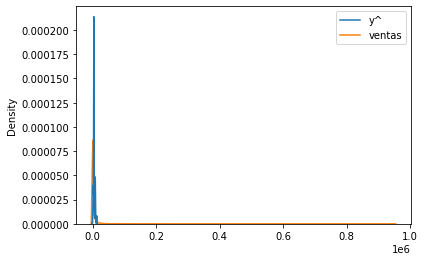

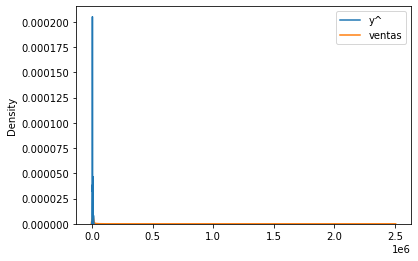

In [93]:
plt.figure()
sns.kdeplot(data=St2[['y^']+vart])
plt.figure()
sns.kdeplot(data=Sv2[['y^']+vart])